# Imports

I'm setting matplotlib to draw nice js widgets, and setting my system to look at the 'procgen-tools' lib that I'm editing, rather than the system version.

In [4]:
%matplotlib widget

In [5]:
# this allows editing of imported modules without restarting kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
sys.path.insert(0,"/home/trist/progging/MIRL/procgen-tools")

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from procgen_tools import maze

In [42]:
from procgen_tools import models

In [16]:
import torch as t

In [17]:
import numpy as np

In [227]:
import os

In [239]:
from pyndsp import to_ndsp_file

In [272]:
from scipy.cluster import hierarchy

# Select Maze

In [8]:
help(maze.create_venv)

Help on function create_venv in module procgen_tools.maze:

create_venv(num: int, start_level: int, num_levels: int, num_threads: int = 1)
    Create a wrapped venv. See https://github.com/openai/procgen#environment-options for params
    
    num=1 - The number of parallel environments to create in the vectorized env.
    
    num_levels=0 - The number of unique levels that can be generated. Set to 0 to use unlimited levels.
    
    start_level=0 - The lowest seed that will be used to generated levels. 'start_level' and 'num_levels' fully specify the set of possible levels.



In [9]:
venv = maze.create_venv(1, num_levels=1, start_level=100)

In [10]:
help(maze.venv_with_all_mouse_positions)

Help on function venv_with_all_mouse_positions in module procgen_tools.maze:

venv_with_all_mouse_positions(venv)
    From a venv with a single env, create a new venv with one env for each legal mouse position.
    
    Returns venv_all, (legal_mouse_positions, inner_grid_without_mouse)
    Typically you'd call this with `venv_all, _ = venv_with_all_mouse_positions(venv)`,
    The extra return values are useful for conciseness sometimes.



In [11]:
venv_all, (legal_mouse_positions, grid, ) = maze.venv_with_all_mouse_positions(venv)

In [32]:
all_mouse_pos = t.tensor(venv_all.reset(), dtype=t.float32)

In [40]:
# chosen because of the interesting position and shape of mouse
myMaze = all_mouse_pos[91].numpy().transpose((1,2,0))

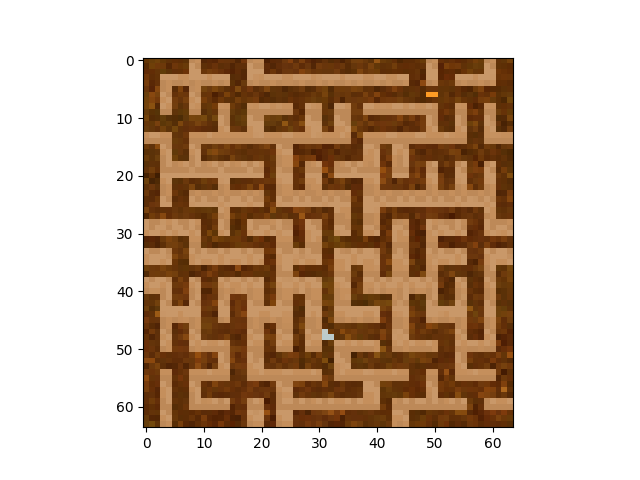

In [41]:
fig,ax = plt.subplots()
ax.imshow(myMaze)

# Get the Policy Model & Activations

## Load Model

In [44]:
myPolicy = models.load_policy('../trained_models/maze_I/model_rand_region_1.pth', 15, t.device('cpu'))

## Attach Hooks

In [167]:
activations = {}

In [142]:
def hook_fn(m, i, o):
    activations[m] = o 

In [216]:
def getHooked(mod):
    if len(mod._modules):
        submod = []
        for m in mod._modules:
            # apparently this can also be done with
            # mod.named_children()
            for k,v,h in getHooked(mod._modules[m]):
                if k:
                    submod+=((m+"."+k, v, h),)
                else:
                    submod+=((m, v, h),)
        return( submod )
    else:
        h = mod.register_forward_hook(hook_fn)
        return( (("",mod,h),) )

In [171]:
hookedList = getHooked(myPolicy.embedder)

In [184]:
len(hookedList)

40

## Run with Hooks

In [172]:
activations

{}

In [173]:
output = myPolicy(t.tensor(myMaze.transpose((2,0,1))).unsqueeze(0))

## Remove Hooks

In [ ]:
for name, layer, hook in hookedList:
    hook.remove()

## Print Info on Activation

In [189]:
#for name, layer, hook in hookedList:
#    print(name)
#    print("-----------")
#    print(layer)
#    print("-----------")
#    print(hook)
#    print("=========================================")

In [240]:
print("="*55+"\n"+"="*13+" "*5+"List of Activations"+" "*5+"="*13+"\n"+"="*55)
names_and_activations = []
for (k,v),(n,l,h) in zip(activations.items(),hookedList):
    print(f"{str(v.shape).rjust(30)} <-- {n}")
    names_and_activations += ((n,v),)

=============     List of Activations     =============
   torch.Size([1, 64, 64, 64]) <-- block1.conv
   torch.Size([1, 64, 32, 32]) <-- block1.maxpool
   torch.Size([1, 64, 32, 32]) <-- block1.res1.relu1
   torch.Size([1, 64, 32, 32]) <-- block1.res1.conv1
   torch.Size([1, 64, 32, 32]) <-- block1.res1.relu2
   torch.Size([1, 64, 32, 32]) <-- block1.res1.conv2
   torch.Size([1, 64, 32, 32]) <-- block1.res1.resadd
   torch.Size([1, 64, 32, 32]) <-- block1.res2.relu1
   torch.Size([1, 64, 32, 32]) <-- block1.res2.conv1
   torch.Size([1, 64, 32, 32]) <-- block1.res2.relu2
   torch.Size([1, 64, 32, 32]) <-- block1.res2.conv2
   torch.Size([1, 64, 32, 32]) <-- block1.res2.resadd
  torch.Size([1, 128, 32, 32]) <-- block2.conv
  torch.Size([1, 128, 16, 16]) <-- block2.maxpool
  torch.Size([1, 128, 16, 16]) <-- block2.res1.relu1
  torch.Size([1, 128, 16, 16]) <-- block2.res1.conv1
  torch.Size([1, 128, 16, 16]) <-- block2.res1.relu2
  torch.Size([1, 128, 16, 16]) <-- block2.res1.conv2
  torc

## Write Activations to Files

In [245]:
import datetime

In [252]:
now = datetime.datetime.now()

In [258]:
dirname = "activations_"+now.isoformat()

In [291]:
os.mkdir(dirname)

FileExistsError: [Errno 17] File exists: 'activations_2024-07-30T01:05:48.898678'

In [292]:
os.path.exists(dirname)

True

In [268]:
for name, activation in names_and_activations:
    to_ndsp_file( activation,
             labels = "zeros",
             title = dirname+"/"+name,
             dimAx = 1,
             afAx = None)

# Interpret Activations by Pixel "Color" Distribution

## Initial Classification by Clustering

### Reshape Activation to Pixels

In [282]:
layer_id = 0

In [283]:
print(names_and_activations[layer_id][0])

block1.conv


In [284]:
activation_img = names_and_activations[layer_id][1]

In [285]:
activation_img.shape

torch.Size([1, 64, 64, 64])

In [286]:
pixels = activation_img.reshape((64,-1))

### Build Hierarchy with scipy

In [360]:
pix_link = hierarchy.linkage(
    pixels.detach().numpy().transpose([1,0]),
    metric='euclidean',
    method='single',
    )

In [361]:
#link_tree = hierarchy.to_tree(pix_link)

### Dendrogram

/tmp/ipykernel_1661594/880322870.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


(-0.02, 0.6)

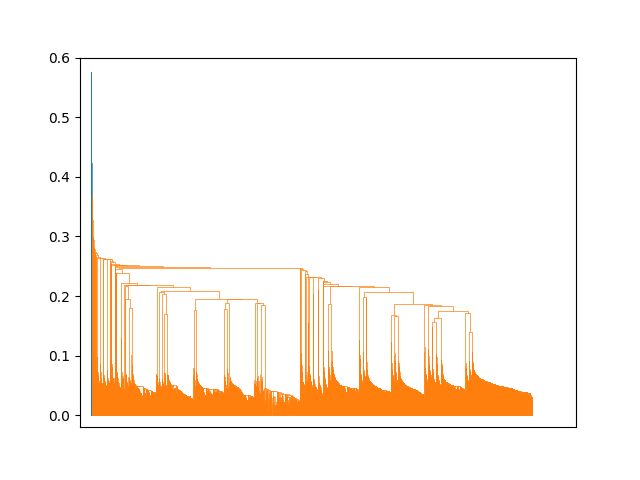

In [362]:
fig, ax = plt.subplots()
acf = ax.add_collection
# dendrogram doesn't have linewidth setting
# but it can be bodged on by hacking the axes
def linmodacf(colec):
    colec.set(linewidth=0.5,)
    acf(colec)
ax.add_collection = linmodacf

ddg=hierarchy.dendrogram(pix_link,
           count_sort='ascending',
           no_labels=True,
           ax=ax,
           )
ax.set_xlim([-1000,45000])
ax.set_ylim([-0.02,0.6])

### Classify by Hierarchy

In [367]:
classif = hierarchy.fcluster(
    pix_link,
    0.2,
    criterion='distance',
    depth=2,
    )

In [368]:
classif.min(), classif.max()

(1, 73)

## Interactive Pixel Cluster Labeling

In [307]:
classif.shape

(4096,)

In [306]:
from pixcluscol import InteractivePixCol

In [369]:
pixCol = InteractivePixCol(  classif.reshape((64,64))  )

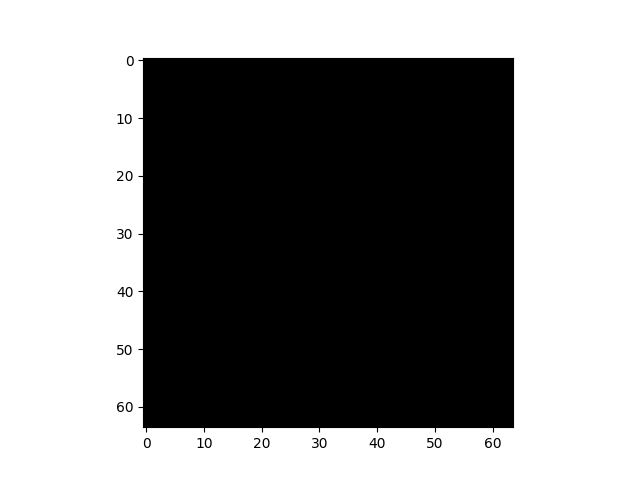

In [371]:
pixCol.drawPlot()